In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

In [2]:
from utils.preprocessing import df_to_xy
#fix rnd seed
np.random.seed(7)

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")

x, y = df_to_xy(df, fuse_risk=True)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5, random_state = 0)

**Loss function**

In [3]:
@np.vectorize
def sigmoid1024(x):
    base = 2000.0**2
    return (base**x/(base**x + 1))

@np.vectorize
def loss(x):
    offset = 1
    x1 = (x + offset) / 16.0
    x2 = (x) / 40.0
    return (1 - sigmoid1024(x1) *  np.cos(x2/np.pi))

def gain(x):
    return 1 - loss(x)

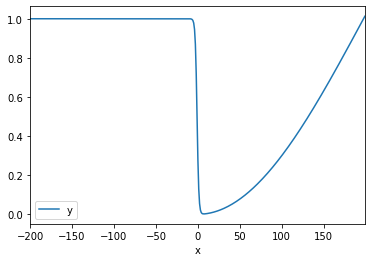

In [4]:
x = np.arange(-200, 200, 1)
y = loss(x)

out_df = pd.DataFrame({'x':x, 'y':y})
out_df.plot.line(x='x', y='y')

In [5]:
from utils.data_augmentation import DACombine

In [6]:
from models.deep import keras_hiddenless_model, keras_model, loss_tf, gain_tf, KerasModel
from keras import backend as K

Using TensorFlow backend.


**Metrics**

In [7]:
from models.metrics import gain_mean

**Model: No data Augmentation**

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


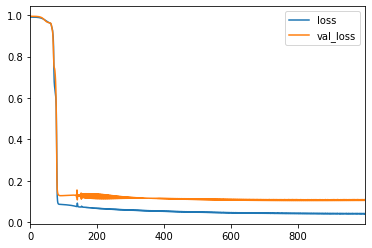

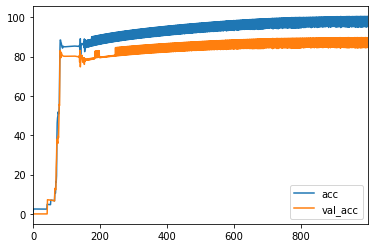

In [8]:
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=256, epochs=1000)
da = DACombine()
xTrain_a, yTrain_a = xTrain.astype(K.floatx()), yTrain.astype(K.floatx())
split = int(xTrain.shape[1] * 0.75)
#xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain, yTrain, size=1024, distance=10)
history = model.fit(xTrain_a.astype(K.floatx()), yTrain_a.astype(K.floatx()),  validation_split=0.25, verbose=0)

#print(history.history)

loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  82.80492226282756


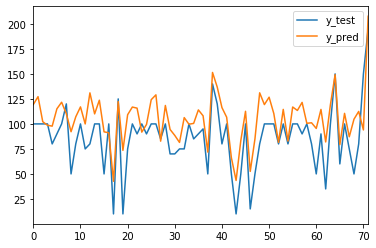

In [9]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

**Model with data augmentation**

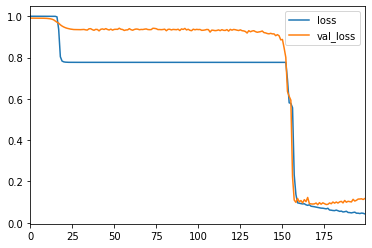

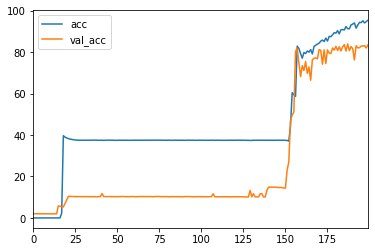

In [10]:
#sci-kit like training
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=30, epochs=200)
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'),  validation_data=(xVal, yVal), verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  80.20858939488728


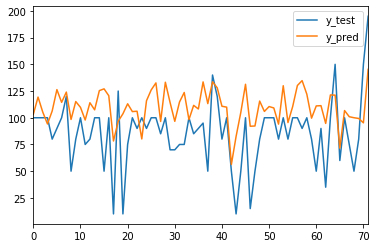

In [11]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

** Model using _mse_ loss and data augmentation**

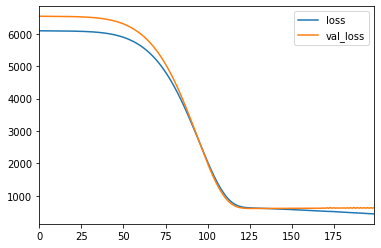

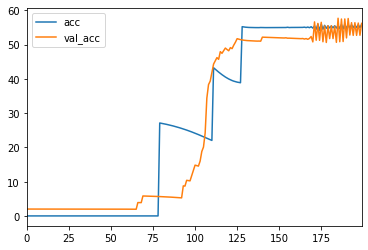

In [12]:
#sci-kit like training
model = KerasModel(loss='mse', metrics=[gain_tf], batch_size=60, epochs=200)
da = DACombine()
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_data=(xVal, yVal))
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  38.77777777777778


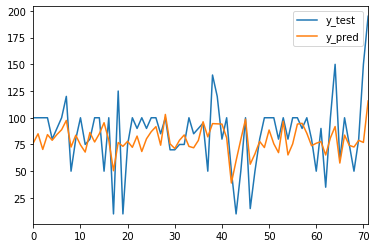

In [13]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

**CMP Model**

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
train gain:  82.78964732517706
gain_mean:  76.7467778523763


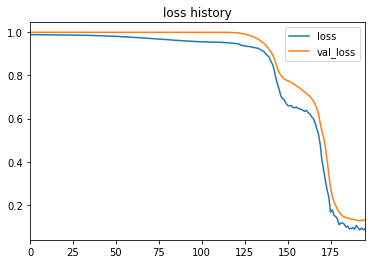

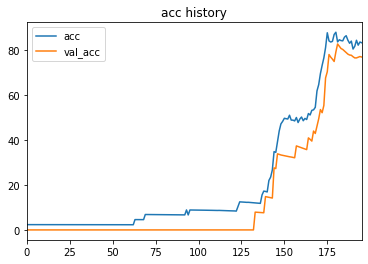

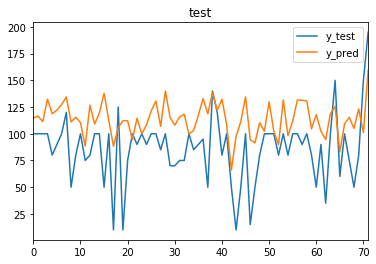

In [14]:
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout

drop_rate = 0.015
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(xTrain.shape[1],)))
model.add(Dropout(rate=drop_rate))
model.add(Dense(275, activation='relu'))
model.add(Dropout(rate=drop_rate))
model.add(Dense(100, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dropout(rate=drop_rate))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=drop_rate))
model.add(Dense(1, activation='linear'))
model.compile(loss=loss_tf,
              optimizer=RMSprop(lr=0.0001),
              metrics=[gain_tf])

history = model.fit(xTrain, yTrain, epochs=196, verbose=0, batch_size=128, validation_split=0.20)

loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(title="loss history")

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(title="acc history")

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = model.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), model.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))

train gain:  98.55140186915888
gain_mean:  83.81944444444444


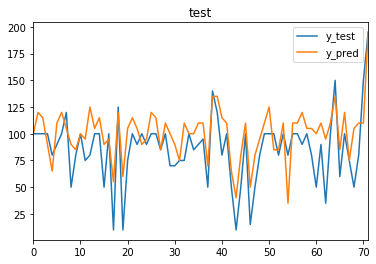

In [15]:
from notebooks.models import AcceptanceModel


drop_rate = 0.15
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(11,)))
model.add(Dropout(rate=drop_rate))
model.add(Dense(275, activation='relu'))
model.add(Dropout(rate=drop_rate))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="mse",
              optimizer='nadam',#optimizer=RMSprop(lr=0.0001),
              metrics=[gain_tf])
amodel = AcceptanceModel(model)
amodel.fit(
    xTrain,
    yTrain,
    fit_kwargs={
        "epochs": 200,
        "batch_size": 10240,
        "validation_split": 0.2,
        "verbose":0
    }
)

yPred = amodel.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = amodel.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), amodel.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))